### Design and train a binary classification model capable to detect a fridge event

In [242]:
import pandas as pd
import seaborn as sns

In [243]:
df = pd.read_csv('fridge_data.csv')
df.columns

Index(['Unnamed: 0', 'index', 'active_power', 'active_power_delta',
       'appliance_name', 'channel', 'current', 'device', 'energy',
       'event_type', 'phase_shift', 'reactive_power', 'reactive_power_delta',
       'seq_id', 'timestamp', 'transient_1', 'transient_10', 'transient_2',
       'transient_3', 'transient_4', 'transient_5', 'transient_6',
       'transient_7', 'transient_8', 'transient_9', 'voltage', 'wifi_strength',
       'peak_1', 'peak_2', 'peak_3', 'peak_4', 'peak_5', 'peak_6', 'peak_7',
       'peak_8', 'peak_9', 'peak_10'],
      dtype='object')

In [244]:
# Dropping empty and irrelevant columns 

relevant_columns = ['timestamp','event_type','current','seq_id','active_power','active_power_delta','reactive_power',
    'reactive_power_delta','transient_1','transient_2','transient_3','transient_4','transient_5','transient_6','transient_7',
    'transient_8','transient_9','transient_10','voltage','peak_1','peak_2','peak_3','peak_4','peak_5','peak_6','peak_7','peak_8',
    'peak_9','peak_10','phase_shift'
]

# Create a new DataFrame with relevant columns
df = df[relevant_columns]

In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   timestamp             80000 non-null  object 
 1   event_type            80000 non-null  object 
 2   current               79865 non-null  float64
 3   seq_id                80000 non-null  int64  
 4   active_power          79982 non-null  float64
 5   active_power_delta    79865 non-null  float64
 6   reactive_power        79845 non-null  float64
 7   reactive_power_delta  79865 non-null  float64
 8   transient_1           79817 non-null  float64
 9   transient_2           79797 non-null  float64
 10  transient_3           79821 non-null  float64
 11  transient_4           79805 non-null  float64
 12  transient_5           79841 non-null  float64
 13  transient_6           79777 non-null  float64
 14  transient_7           79809 non-null  float64
 15  transient_8        

#### Fixing the timestamp and splitting it into hours and minutes may reveal correlations between the hour of the day and the events.

In [246]:
# Convert the 'timestamp' column to datetime with milliseconds
df['timestamp'] = pd.to_datetime(df['timestamp'], format="%Y-%m-%d %H:%M:%S.%f", errors='coerce')

# Reformat the 'timestamp' column to "yyyy-mm-dd hh:mm:ss"
df['timestamp'] = df['timestamp'].dt.strftime("%Y-%m-%d %H:%M:%S")

# Convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], format="%Y-%m-%d %H:%M:%S")

#Extract hour and minute Components
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute

# droping timestamp column 
df.drop('timestamp', axis=1, inplace=True)

# Define a dictionary to map values
event_type_mapping = {'KA': 0, 'ON': 1, 'OFF': 1}

# Use the map method to update the 'event_type' column
df['event_type'] = df['event_type'].map(event_type_mapping)


In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   event_type            80000 non-null  int64  
 1   current               79865 non-null  float64
 2   seq_id                80000 non-null  int64  
 3   active_power          79982 non-null  float64
 4   active_power_delta    79865 non-null  float64
 5   reactive_power        79845 non-null  float64
 6   reactive_power_delta  79865 non-null  float64
 7   transient_1           79817 non-null  float64
 8   transient_2           79797 non-null  float64
 9   transient_3           79821 non-null  float64
 10  transient_4           79805 non-null  float64
 11  transient_5           79841 non-null  float64
 12  transient_6           79777 non-null  float64
 13  transient_7           79809 non-null  float64
 14  transient_8           79835 non-null  float64
 15  transient_9        

#### Trying to address missing values by leveraging their relationships with other columns.

In [248]:
import pandas as pd

''''

This function counts the occurrences of exactly one missing value within sets of columns
'current', 'peak_i', and 'transient_i.' It facilitates the filling of these missing values according to the definition
that transient_i = peak_i - current

'''
# Create a new column 'missing_count' that counts the number of missing values in each set of columns
for i in range(1, 11):
    peak_col = f'peak_{i}'
    transient_col = f'transient_{i}'
    current_col = 'current'
    df[f'missing_count_{i}'] = df[[current_col, peak_col, transient_col]].isna().sum(axis=1)

# Count how many times in each set there's exactly one missing value
counts_one_missing = []
for i in range(1, 11):
    count_one_missing = len(df[df[f'missing_count_{i}'] == 1])
    counts_one_missing.append(count_one_missing)
    print(f"Number of times with one missing value in set {i}: {count_one_missing}")

# If you want to get a list of counts for all sets
print("Counts for all sets:", counts_one_missing)


Number of times with one missing value in set 1: 0
Number of times with one missing value in set 2: 0
Number of times with one missing value in set 3: 0
Number of times with one missing value in set 4: 0
Number of times with one missing value in set 5: 0
Number of times with one missing value in set 6: 0
Number of times with one missing value in set 7: 0
Number of times with one missing value in set 8: 0
Number of times with one missing value in set 9: 0
Number of times with one missing value in set 10: 0
Counts for all sets: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


#### Filling missing values using the mean method and interpolation

In [249]:
import pandas as pd

# Replace missing values using mean imputation
columns_to_fill = {
    'current': 'mean',
    'active_power': 'mean',
    'reactive_power': 'mean',
    'phase_shift': 'mean',
    'active_power_delta': 'mean',
    'reactive_power_delta': 'mean',
    'voltage': 'mean',
}

# Apply mean imputation to the specified columns using .fillna()
for column, method in columns_to_fill.items():
    if method == 'mean':
        mean_value = df[column].mean()
        df[column].fillna(mean_value, inplace=True)

# Fill missing values in transient and peak columns using interpolation
transient_columns = ['transient_1', 'transient_2', 'transient_3', 'transient_4', 'transient_5', 'transient_6', 'transient_7', 'transient_8', 'transient_9', 'transient_10']
peak_columns = ['peak_1', 'peak_2', 'peak_3', 'peak_4', 'peak_5', 'peak_6', 'peak_7', 'peak_8', 'peak_9', 'peak_10']

# to avoid SettingWithCopy warnings
df = df.copy()
df[transient_columns] = df[transient_columns].interpolate(method='linear', axis=0)
df[peak_columns] = df[peak_columns].interpolate(method='linear', axis=0).copy()

# to avoid warnings
pd.options.mode.chained_assignment = None


In [250]:
df.isna().sum()

event_type              0
current                 0
seq_id                  0
active_power            0
active_power_delta      0
reactive_power          0
reactive_power_delta    0
transient_1             0
transient_2             0
transient_3             0
transient_4             0
transient_5             0
transient_6             0
transient_7             0
transient_8             0
transient_9             0
transient_10            0
voltage                 0
peak_1                  0
peak_2                  0
peak_3                  0
peak_4                  0
peak_5                  0
peak_6                  0
peak_7                  0
peak_8                  0
peak_9                  0
peak_10                 0
phase_shift             0
hour                    1
minute                  1
missing_count_1         0
missing_count_2         0
missing_count_3         0
missing_count_4         0
missing_count_5         0
missing_count_6         0
missing_count_7         0
missing_coun

In [251]:
df.dropna(subset=['hour', 'minute'], inplace=True)

# The data frame is ready for machine learning preprocessing

In [252]:
df['event_type'].value_counts()

event_type
0    46320
1    33679
Name: count, dtype: int64

<Axes: xlabel='event_type', ylabel='count'>

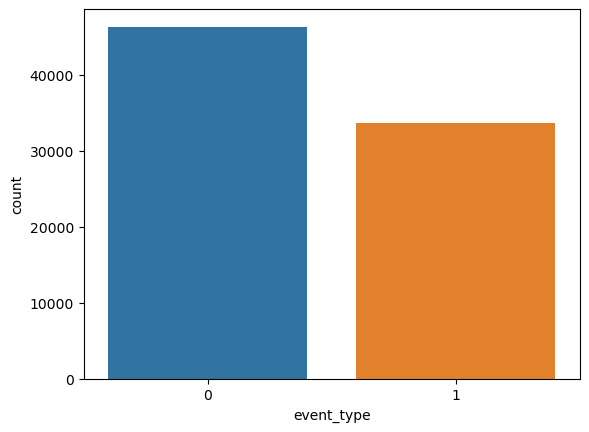

In [253]:
sns.countplot(x='event_type', data=df)

#### correlations check

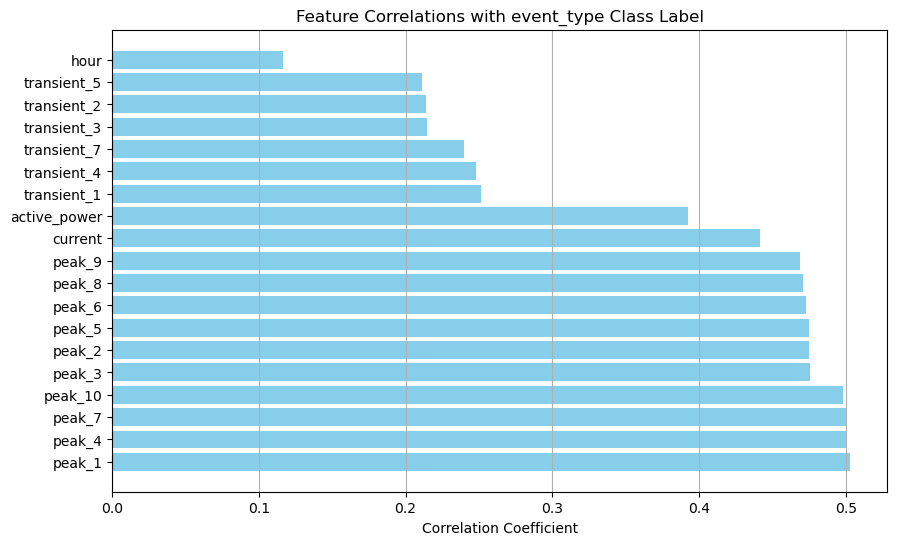

In [257]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Ensure class label event_type is numeric 
df['event_type'] = df['event_type'].astype(int)

# Calculate the point-biserial correlation coefficient for each numeric feature with the class label event_type
class_label = 'event_type'
correlations = {}
# Point-Biserial Correlation: to measure the strength and direction of the association that exists between one binary variable 
#(e.g., class label) and one continuous variable (e.g., feature). It is a special case of the Pearson correlation coefficient, 
#where one of the variables is dichotomous (has only two possible outcomes).
for feature in df.select_dtypes(include=['number']).columns:
    if feature != class_label:
        correlation, p_value = stats.pointbiserialr(df[class_label], df[feature])
        correlations[feature] = correlation

# Sort the features by their correlation coefficient in descending order
sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

# Extract feature names and correlation values
feature_names, correlation_values = zip(*sorted_correlations)

# Create a bar chart to visualize the correlations
plt.figure(figsize=(10, 6))
plt.barh(feature_names, correlation_values, color='skyblue')
plt.xlabel('Correlation Coefficient')
plt.title('Feature Correlations with event_type Class Label')
plt.grid(axis='x')
plt.show()


In [258]:
# features with a relatively high absolute correlation

corr_columns = ['event_type','active_power','current','transient_1','transient_2','transient_3','transient_4','transient_5',
    'transient_7','peak_1','peak_2','peak_3','peak_4','peak_5','peak_6','peak_7','peak_8','peak_9','peak_10','hour']

# Create a new DataFrame with relevant columns
df = df[corr_columns]

<Axes: xlabel='hour', ylabel='active_power'>

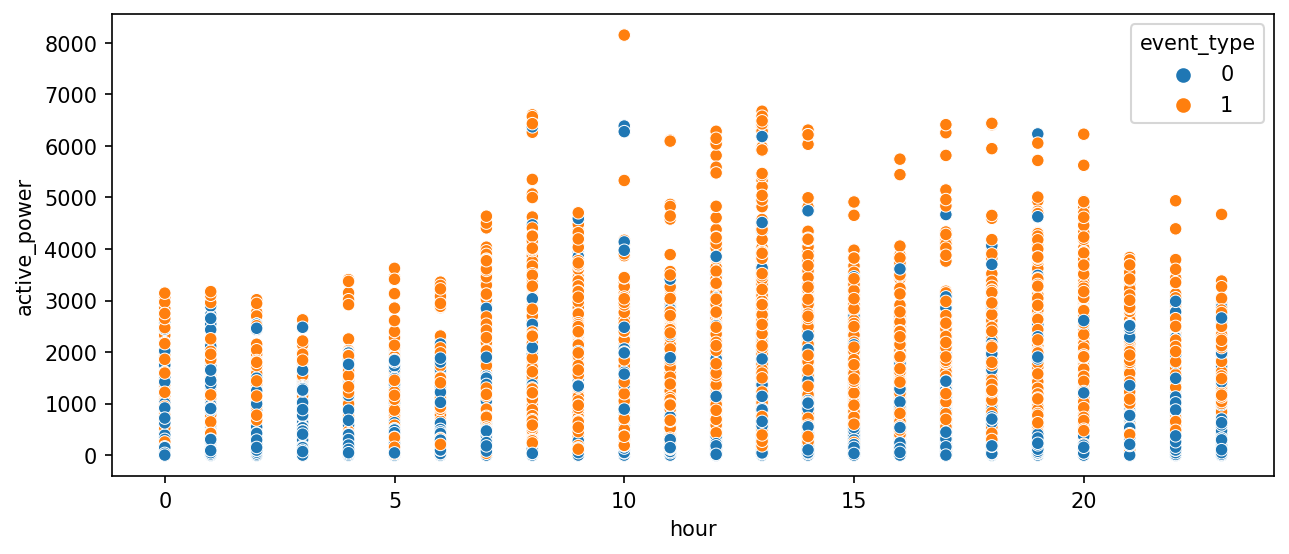

In [259]:
# ON/OFF events (class 1) and 'KEEP ALIVE' events (class 0)

plt.figure(figsize=(10, 4), dpi=150)
sns.scatterplot(data=df, x='hour', y='active_power', hue='event_type')

# Randome Forest Model Design 

In [260]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

n_estimators=100: This parameter defines the number of trees in the forest. In this case, 100 trees will be used in the ensemble. 

random_state=42: This parameter is used for initializing the internal random number generator, which will decide the splitting of data at each node and the selection of features for splitting at each tree. The value 42 is just a commonly used arbitrary number. 

In [261]:
# features (X) and target variable (y)
X = df[['active_power','current','transient_1','transient_2','transient_3','transient_4','transient_5', 'transient_7',
    'peak_1', 'peak_2', 'peak_3','peak_4','peak_5','peak_6','peak_7','peak_8','peak_9','peak_10','hour',]]
y = df["event_type"]


# training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

In [262]:
# Train the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(classification_rep)

Accuracy: 0.9553
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      9254
           1       0.92      0.97      0.95      6746

    accuracy                           0.96     16000
   macro avg       0.95      0.96      0.95     16000
weighted avg       0.96      0.96      0.96     16000



## Summary

##### The model is performing well in distinguishing between ON/OFF events (class 1) and 'KEEP ALIVE' events (class 0). The high precision and recall for both classes suggest that the model effectively identifies ON/OFF events while maintaining a low rate of false positives. This balance between precision and recall, as reflected in the F1-scores and weighted average, indicates that the model is reliable for classifying these events

**Accuracy (0.9553)**: This parameter represents the proportion of total correct predictions (both ON/OFF and KEEP ALIVE events) out of all predictions made. An accuracy of 0.9553 means that approximately 95.53% of the model's predictions were correct.

**Precision (ON/OFF: 0.92, KEEP ALIVE: 0.98)**: Precision measures the proportion of correct positive identifications; it is the number of true positives divided by the total number of positive predictions. For ON/OFF events, when the model predicts an event, it is correct 92% of the time, and for KEEP ALIVE events, it is correct 98% of the time.

**Recall (ON/OFF: 0.97, KEEP ALIVE: 0.94)**: Recall (or sensitivity) measures the proportion of actual positives that were identified correctly; it is the number of true positives divided by the total number of actual positives. For ON/OFF events, the model correctly identifies 97% of all actual ON/OFF events, and for KEEP ALIVE, it correctly identifies 94%.

**F1-Score (ON/OFF: 0.95, KEEP ALIVE: 0.96)**: The F1-score is the harmonic mean of precision and recall, providing a balance between the two. It's particularly useful when the class distribution is imbalanced. For ON/OFF events, the model's F1-score is 0.95, and for KEEP ALIVE events, it's 0.96, indicating a good balance between precision and recall for both classes.

**Macro Avg**: This is the average of the precision, recall, and F1-score for each class, without weighting for class imbalance. A macro average of 0.95 suggests that the model performs well across both classes.

**Weighted Avg**: This is the average of precision, recall, and F1-score for each class, weighted by the number of true instances for each class. This accounts for class imbalance. A weighted average of 0.96 indicates the model is performing well overall, with weighting according to the prevalence of each class.

**General Interpretation**:
The model shows high performance in distinguishing between ON/OFF and KEEP ALIVE events with high accuracy, precision, recall, and F1-scores. The high recall for ON/OFF events suggests the model is very effective at detecting these critical events, while the high precision for KEEP ALIVE events indicates a strong ability to correctly label non-critical events. The balanced F1-scores indicate that the model is robust in its performance across both classes.